<a href="https://colab.research.google.com/github/brenoskuk/image_processing_exercises/blob/master/skin_lesion_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin lesion classification

**Deadline**: Upload this notebook (rename it as 'TP2-SVM-IMA205-YOUR-SURNAME.ipynb') and the answers to the theoretical questions as a single zip file to the site pédagogique before the 12th of February 2020 (23h59). Name it as 'TP2-SVM-IMA205-YOUR-SURNAME.zip'.

**Context**
A skin lesion is defined as a superficial growth or patch of the skin that is visually different and/or has a different texture than its surrounding area. Skin lesions, such as moles or birthmarks, can degenerate and become melanoma, one of the deadliest skin cancer. Its incidence has been increasing during the last decades, especially in the areas mostly populated by white people.

The most effective treatment is an early detection followed by surgical excision. This is why several approaches for melanoma detection have been proposed in the last years (non-invasive computer-aided diagnosis (CAD) ).


**Goal**
The goal of this practical session is to classify images of skin lesions as either benign or melanoma using machine learning algorithms. In order to do that, you will have at your disposal a set of 30 features already extracted from 600 dermoscopic images (both normal skin lesions and melanoma from the ISIC database - https://isic-archive.com/). These features characterize the Asymmetry, the Border irregularity, the Colour and the Dimension of the lesion (the so-called ABCD rule). 

The features are:
- shape asimmetry (f0 and f1)
- difference in colors between center and periphery of the image (f2, f3, f4, f27, f28, f29)
- geometry (f5, f6, f7)
- other features related to eccentricity,entropy, mean, standard deviation and maximum value of each channel in RGB and HSV (f8,...,f24)
- asimmetry of color intensity (f25, f26)

Features are computed using *manually checked segmentations* and following *Ganster et al. 'Automated melanoma recognition', IEEE TMI, 2001* and *Zortea et al. 'Performance of a dermoscopy-based computer vision system for the diagnosis of pigmented skin lesions compared with visual evaluation by experienced dermatologists', Artificial Intelligence in Medicine, 2014*.

First load all necessary packages

In [ ]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

# Code from scikit-learn
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


Then load the data from my Google Drive

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd
gdd.download_file_from_google_drive(file_id='18hrQVGBCfW7SKTnzmWUONo8iowBsi1DL',
dest_path='./data/features.csv')
gdd.download_file_from_google_drive(file_id='1iQZdUiuK_FwZ7mik7LB3eN_H_IUc5l7b',
dest_path='./data/im/nevus-seg.jpg')
gdd.download_file_from_google_drive(file_id='1_TeYzLLDoKbPX4xXAOAM_mQiT2nLHgvp',
dest_path='./data/im/nevus.jpg')
gdd.download_file_from_google_drive(file_id='1B2Ol92mBcHN6ah3bpoucBbBbHkPMGC8D',
dest_path='./data/im/melanoma-seg.jpg')
gdd.download_file_from_google_drive(file_id='1yZ46UzGhwO7g5T8397JpewBl6UqgRo5J',
dest_path='./data/im/melanoma.jpg')

Or from yout local computer. Please download the 'data' folder in the same folder as your notebook and do not modifiy it.

Then read the data 

In [ ]:
## Read data
Working_directory="./data/" 
df = pd.read_csv(Working_directory + 'features.csv') # reading data
y = df['Malignant'].values # 1 for Melanoma and 0 for healthy
class_names = ["healthy","melanoma"]
X = df.iloc[:,3:33].values # Features
N,M=X.shape
print('Number of images: {0}; Number of features per image: {1}'.format(N,M))
print('Number of healthy nevus: {0}; Number of melanoma: {1}'.format(N-np.sum(y), np.sum(y)))


Number of images: 600; Number of features per image: 30
Number of healthy nevus: 485; Number of melanoma: 115


In [ ]:
df.head

<bound method NDFrame.head of       Id    ImageId  Malignant  ...       f27       f28       f29
0      0  IM_000498          0  ...  0.523051  0.246898  0.200719
1      1  IM_000617          0  ...  0.194775  0.138669  0.131058
2      2  IM_000394          0  ...  0.713965  0.735100  0.842481
3      3  IM_000244          0  ...  0.360376  0.348889  0.332280
4      4  IM_000599          0  ...  0.682795  0.433356  0.376376
..   ...        ...        ...  ...       ...       ...       ...
595  595  IM_000309          0  ...  0.433436  0.342468  0.283927
596  596  IM_000844          0  ...  0.521805  0.185827  0.174616
597  597  IM_000058          0  ...  0.189817  0.177013  0.185952
598  598  IM_000627          0  ...  0.229295  0.254076  0.236316
599  599  IM_000092          1  ...  0.599979  0.581899  0.600968

[600 rows x 33 columns]>

Two examples of healthy nevus and melanoma


Text(0.5, 1.0, 'Segmented melanoma')

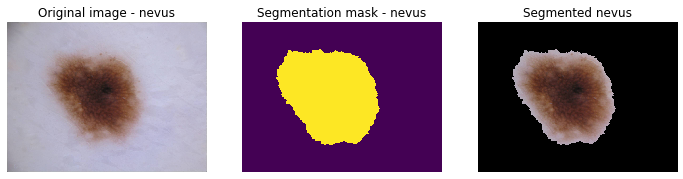

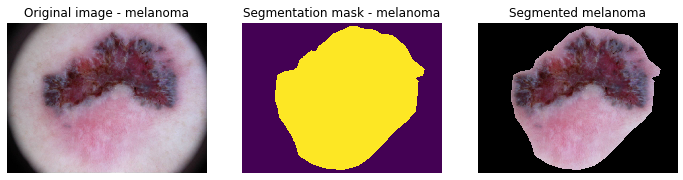

In [ ]:
## Plot two examples of nevus and melanoma
print('Two examples of healthy nevus and melanoma')
nevus = imread(Working_directory + 'im/nevus.jpg')
nevus_Segmentation = imread(Working_directory + 'im/nevus-seg.jpg') 
nevus_Segmentation_boolean = (nevus_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
nevus_Segmentation_3D = np.expand_dims(nevus_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
nevus_mul_mask = (nevus_Segmentation_3D*nevus) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(nevus)
grid[0].axis('off')
grid[0].set_title('Original image - nevus')
grid[1].imshow(nevus_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - nevus")
grid[2].imshow(nevus_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented nevus")

###

melanoma = imread(Working_directory + 'im/melanoma.jpg')
melanoma_Segmentation = imread(Working_directory + 'im/melanoma-seg.jpg') 
melanoma_Segmentation_boolean = (melanoma_Segmentation/255).astype(np.uint8) # To get uint8 (integer numbers)
melanoma_Segmentation_3D = np.expand_dims(melanoma_Segmentation_boolean, axis=2) # To have a binary mask for the three channels (RGB)
melanoma_mul_mask = (melanoma_Segmentation_3D*melanoma) # we apply the binary mask to all channels pixel-wise

fig = plt.figure(figsize=(12, 12)) # size of the figure
grid = AxesGrid(fig, 111,
                nrows_ncols = (1, 3),
                axes_pad = 0.5) # code to create subplots
grid[0].imshow(melanoma)
grid[0].axis('off')
grid[0].set_title('Original image - melanoma')
grid[1].imshow(melanoma_Segmentation)
grid[1].axis('off')
grid[1].set_title("Segmentation mask - melanoma")
grid[2].imshow(melanoma_mul_mask)
grid[2].axis('off')
grid[2].set_title("Segmented melanoma")


Now, as in the previous practical session you should shuffle the data randomly

In [ ]:
# Shuffle data randomly

shuffle_order = np.arange(N)
np.random.shuffle(shuffle_order)

# Use as new variables
yp=y[shuffle_order]
Xp=X[shuffle_order]


As we have already seen, it might be very important to scale the data such that each feature has, for instance, average equal to 0 and unit variance.

In [ ]:
# Scale data (each feature will have average equal to 0 and unit variance)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler()
scaler.fit(Xp)
Xps=scaler.transform(Xp)


We should now test the discriminative power of our features. Let divide the entire data-set into training and test set and use two simple classification algorithms, a linear and a quadratic one... Look at the confusion matrices and comment the results. 

In [ ]:
# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xps, np.ravel(yp), test_size=0.33, random_state=42)


Fitting LDA to training set
done in 0.014s
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       159
           1       0.36      0.23      0.28        39

    accuracy                           0.77       198
   macro avg       0.59      0.57      0.57       198
weighted avg       0.73      0.77      0.75       198

Normalized confusion matrix
[[0.89937107 0.10062893]
 [0.76923077 0.23076923]]


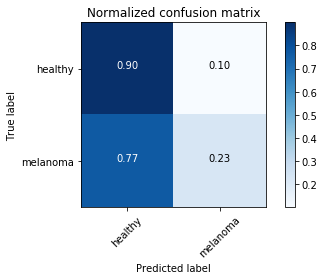

In [ ]:
# Linear Fitting (LDA) to original data
print("Fitting LDA to training set")
t0 = time()
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Fitting QDA
done in 0.008s
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       159
           1       0.41      0.23      0.30        39

    accuracy                           0.78       198
   macro avg       0.62      0.57      0.58       198
weighted avg       0.75      0.78      0.76       198

Normalized confusion matrix
[[0.91823899 0.08176101]
 [0.76923077 0.23076923]]


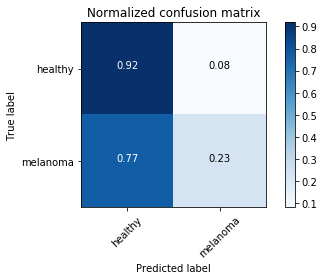

In [ ]:
# Fitting QDA
print("Fitting QDA")
t0 = time()
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred = qda.predict(X_test)
print("done in %0.3fs" % (time() - t0))
print(classification_report(y_test, y_pred))

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


**Comment**: The models works reasonably well for classyfing healthy tissue, but is biased towards it, and is classifying melanoma as healthy.



The results you obtained are based on a precise subdivision of your data into training and test. This can thus bias your results. Which technique could you use instead ? Test it with at least three different models (e.g. LDA, QDA, K-NN, etc)

**Answer**: We can use K-folds to find the best division in training and testing sets that isn't biased towards classifying melanoma as healthy tissue.

kFolds on LDA
Normalized confusion matrix
[[0.91525424 0.08474576]
 [0.5625     0.4375    ]]


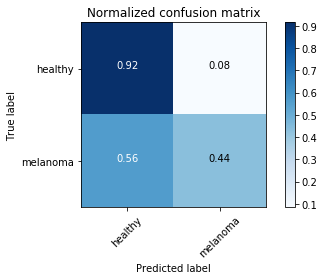

kFolds on QDA
Normalized confusion matrix
[[0.98305085 0.01694915]
 [0.5        0.5       ]]


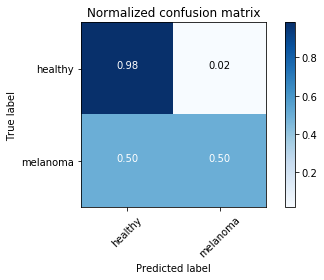

kFolds on K-nearest neighbour
Normalized confusion matrix
[[0.91071429 0.08928571]
 [0.78947368 0.21052632]]


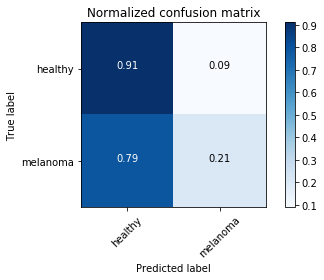

In [ ]:
from sklearn.metrics import f1_score
n_splits = 8
kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
yb_pred = []
yb_test = []
# Fitting LDA 
print("kFolds on LDA")
best_score = 0
for train_index, test_index in kf.split(Xps):
  # Fitting
  X_train, X_test = Xps[train_index], Xps[test_index]
  y_train, y_test = yp[train_index], yp[test_index]
  lda = LinearDiscriminantAnalysis()
  lda.fit(X_train, y_train)
  y_pred = lda.predict(X_test)
  # f1 score
  score = f1_score(y_test, y_pred)
  if score > best_score:
    best_score = score
    yb_pred = y_pred
    yb_test = y_test

# Compute confusion matrix
cnf_matrix = confusion_matrix(yb_test, yb_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Fitting QDA
print("kFolds on QDA")
best_score = 0
for train_index, test_index in kf.split(Xps):
  # Fitting
  X_train, X_test = Xps[train_index], Xps[test_index]
  y_train, y_test = yp[train_index], yp[test_index]
  qda = QuadraticDiscriminantAnalysis()
  qda.fit(X_train, y_train)
  y_pred = qda.predict(X_test)
  # f1 score
  score = f1_score(y_test, y_pred)
  if score > best_score:
    best_score = score
    yb_pred = y_pred
    yb_test = y_test


# Compute confusion matrix
cnf_matrix = confusion_matrix(yb_test, yb_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

# Fitting K-nearest neighbour
print("kFolds on K-nearest neighbour")
best_score = 0
for train_index, test_index in kf.split(Xps):
  # Fitting
  X_train, X_test = Xps[train_index], Xps[test_index]
  y_train, y_test = yp[train_index], yp[test_index]
  KNN = KNeighborsClassifier(n_neighbors=8)
  KNN.fit(X_train, y_train)
  y_pred = KNN.predict(X_test)
  # f1 score
  score = f1_score(y_test, y_pred)
  if score > best_score:
    best_score = score
    yb_pred = y_pred
    yb_test = y_test


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


When using K-NN, instead than fixing the number of nearest neighbours, we could also estimate the best value. Do it and plot the confusion matrix. Do you notice anything strange ? 

**Answer**: Yes. The confusion matrix still indicates that there is bias, even when when there is a very good score. There may be some other problem with the way we are treating the dataset...

The best K is 9  with an average validation score equal to  0.8200000000000001
kFolds on K-nearest neighbour
Normalized confusion matrix
[[0.91071429 0.08928571]
 [0.78947368 0.21052632]]


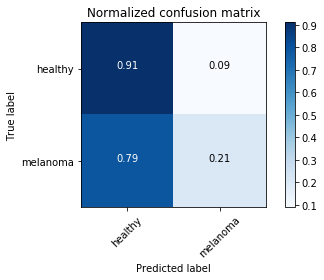

In [ ]:
# Looking for the best K in K-nearest neighbour
parameters = {'n_neighbors':range(15)}
neighCV = KNeighborsClassifier()
grid = GridSearchCV(neighCV, parameters, cv=8, n_jobs=-1)
grid.fit(Xps, np.ravel(yp))


print('The best K is', grid.best_params_.get('n_neighbors'), ' with an average validation score equal to ', grid.best_score_)

# Create training and test set
X_train, X_test, y_train, y_test = train_test_split(Xps, np.ravel(yp), test_size=0.33, random_state=42)

n_neigh = int(grid.best_params_.get('n_neighbors'))

# Fitting K-nearest neighbour 
print("kFolds on K-nearest neighbour")
best_score = 0
for train_index, test_index in kf.split(Xps):
  # Fitting
  X_train, X_test = Xps[train_index], Xps[test_index]
  y_train, y_test = yp[train_index], yp[test_index]
  KNN = KNeighborsClassifier(n_neighbors=n_neigh)
  KNN.fit(X_train, y_train)
  y_pred = KNN.predict(X_test)
  # f1 score
  score = f1_score(y_test, y_pred)
  if score > best_score:
    best_score = score
    yb_pred = y_pred
    yb_test = y_test


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()


I strongly suggest that you look at these two web-pages: 
- https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter, and try other scoring functions with at least one of the 3 previous models.
- https://imbalanced-learn.readthedocs.io/en/stable/over_sampling.html and try at least one naive random over-sampling (look at the following code...).

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(Xps, yp, test_size=0.33, random_state=2)
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 332), (1, 332)]


Let's retest KNN on this new data-set. Are the results better ?

**Answer**: They are less biased as the confision matrix shows better errors of missclassification. This is a somewhat better cancer test since the worst error case (classifying cancer as healthy nevus) has greatly diminished. This probably means the dataset is unbalanced. We should try other methods.

kFolds on K-nearest neighbour
Normalized confusion matrix
[[0.62745098 0.37254902]
 [0.31111111 0.68888889]]


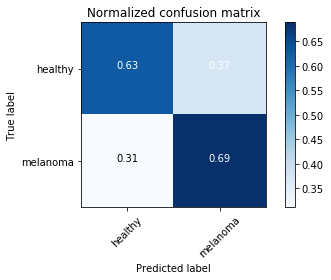

In [ ]:
# Fitting KNN 
print("kFolds on K-nearest neighbour")
KNN = KNeighborsClassifier(n_neighbors=n_neigh)
KNN.fit(X_resampled, y_resampled)
y_pred = KNN.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Let's use more advanced techiques such as SVM

In [ ]:
# Fitting Linear SVM on original data
print("Fitting Linear SVM to the training set")
t0 = time()
Lsvm = LinearSVC(class_weight='balanced') # class_weight needs to be set as balanced when classes are imabalanced > https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
Lsvm_score = cross_val_score(Lsvm, X_resampled, y_resampled, cv=5,scoring='f1')
print("done in %0.3fs" % (time() - t0))
print(" Average and std CV score : {0} +- {1}".format(lda_score.mean(), lda_score.std() ))

Fitting Linear SVM to the training set
done in 0.338s
 Average and std CV score : 0.8150000000000001 +- 0.01433720877840439


Suppose that there are overlapping classes, we need to set the hyper-parameter C. Use Cross-Validation to find the best C value.

The best C is 0.01  with an average validation score equal to  0.46984030072347877
Normalized confusion matrix
[[0.77777778 0.22222222]
 [0.55555556 0.44444444]]


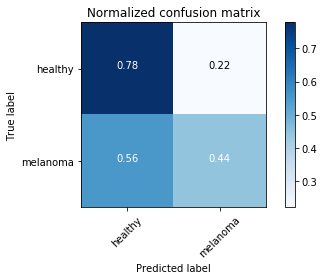

In [ ]:
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')

# grid search solves the problem of finding hyperparameters
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1, scoring='f1')
grid.fit(Xps, np.ravel(yp))
best_C = grid.best_params_.get('C')
print('The best C is', best_C, ' with an average validation score equal to ', grid.best_score_)

Lsvm = LinearSVC(C=best_C)
Lsvm.fit(X_resampled, np.ravel(y_resampled))
y_pred = Lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Try to use the previous SVM code but on the over-sampled data. Does the scoring result change ? 

**Answer** Yes. The bias gets even stronger than before and it has classified all tissue as healthy tissue!

The best C is 0.01  with an average validation score equal to  0.46984030072347877
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


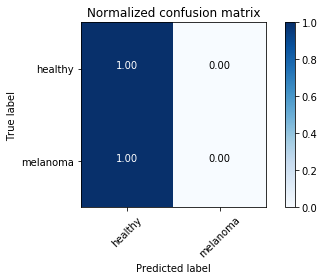

In [ ]:
# Fitting Linear SVM on over-sampled data
# Looking for the best hyperparameter C 
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
Lsvm = LinearSVC(class_weight='balanced')

# grid search solves the problem of finding hyperparameters
grid = GridSearchCV(Lsvm, p_grid_lsvm, cv=5, n_jobs=-1, scoring='f1')
grid.fit(Xps, np.ravel(yp))
best_C = grid.best_params_.get('C')
print('The best C is', best_C, ' with an average validation score equal to ', grid.best_score_)

# Create training and test
X_train, X_test, y_train, y_test = train_test_split(Xp, np.ravel(yp), test_size=0.33, random_state=42)

Lsvm = LinearSVC(C=best_C)
Lsvm.fit(X_resampled, np.ravel(y_resampled))
y_pred = Lsvm.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

Here it is the code for non-linear SVM using radial basis function. We need to tune another hyper-parameter $gamma$. We look for the best $C$ and $gamma$ at the same time.

**Comment**

Non-linear SVM has better results using the F1 score. Finding the best C and the best $\gamma$ has given us a f1-score of 98%! This is much higher than all other models. This sugest that it's a good method for working with  we are using the over-sampled sets for training, making us believe for sure that it can be very useful.

In [ ]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf', class_weight='balanced')
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Nested CV with parameter optimization
clf = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, cv=inner_cv)
nested_score = cross_val_score(clf, X_resampled, y_resampled, cv=outer_cv)
print("done in %0.3fs" % (time() - t0))
print("Average and std Nested Cv score : {0} +- {1}".format(nested_score.mean(), nested_score.std() ))

# Looking for the best hyperparameters
grid_nlsvm = GridSearchCV(estimator=NLsvm, param_grid=p_grid_nlsvm, scoring="f1", cv=5)
grid_nlsvm.fit(X_resampled, np.ravel(y_resampled))
print("Best Score: {}".format(grid_nlsvm.best_score_))
print("Best params: {}".format(grid_nlsvm.best_params_))




Fitting Non-linear SVM to the training set
done in 34.213s
Average and std Nested Cv score : 0.9744133059922533 +- 0.010175551853805306
Best Score: 0.9851622569251145
Best params: {'C': 2, 'gamma': 0.1}


Another important point is the importance of the single features.
The more naive technique would be to test each feature independently in a greedy fashion called sequential forward feature selection. Starting from an empty set and a classification model, you will first add the feature that maximizes a certain criterion (i.e. balanced accuracy). Then, you will iterate this process until a chosen stopping criterion by adding at each iteration only the best feature. Each feature can be added of course only once. You could also use the opposite process by removing at each iteraton the least important feature starting from the entire set of features (i.e. sequential backward feature selection). Implement at least one of these ideas. 

**Comment**: We obtained the same result with QDA (still biased) but using only some features (4). This suggest that the dataset has more information than needed to classify features. Other analysis could be done using the confusion matrix as a metric for selecting features. 

In [ ]:
def LDA_kFolds(Xps, Yps, n_splits = 8):
  kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
  yb_pred = []
  yb_test = []
  # Fitting LDA 
  best_score = 0
  for train_index, test_index in kf.split(Xps):
    # Fitting
    X_train, X_test = Xps[train_index], Xps[test_index]
    y_train, y_test = yp[train_index], yp[test_index]
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    y_pred = lda.predict(X_test)
    # f1 score
    score = f1_score(y_test, y_pred)
    if score > best_score:
      best_score = score
      yb_pred = y_pred
      yb_test = y_test

  return best_score, y_pred, y_test


columns of selected features:  [12, 7, 16, 22]
Normalized confusion matrix
[[1.         0.        ]
 [0.78947368 0.21052632]]


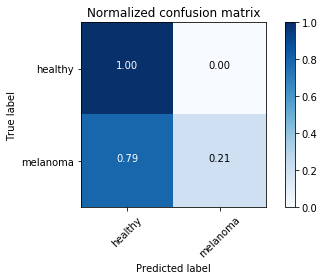

In [ ]:
# initializes empty array of features
feats = []
best_score = 0
for i in range(M):
  # adding feature
  feats.append(i)
  score, _, _ = LDA_kFolds(Xps[:,feats], yp)
  if score < best_score:
    feats.pop()
  else:
    best_score = score
  #removing unwanted features
  n_feats = len(feats)
  if(n_feats > 1):
    j = 0
    while (j < n_feats and n_feats > 1):
      removed = feats.pop(j)
      score, _, _ = LDA_kFolds(Xps[:,feats], yp)
      if score < best_score:
        feats.append(removed)
      else:
        j = j - 1
        n_feats = n_feats - 1
        best_score = score
      j = j + 1

score, y_pred, y_test = LDA_kFolds(Xps[:,feats], yp)

print("columns of selected features: ", feats)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()
